In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

# %cd /content/drive/MyDrive/ChesapeakeBay/ChesapeakeBayChlorophyll/notebooks/models

# Introduction

This notebook will provide further cleaning for all three datasets. Most sections end with exporting the dataset to a file for later use.

This notebook will combine the satellite chlorophyll data downloaded in [`ChesapeakeBaySatellite.ipynb`]('notebooks/APIs/ChesapeakeBaySatellite.ipynb') with the buoy based weather data from [`data/buoy_aggregate.csv`]('../../data/buoy_aggregate.csv') in order to use the data in our model. It will also prepare the [`data/water_cleaned.csv`]('../data/water_cleaned.csv') data for the model.

In [2]:
import pandas as pd
import numpy as np
import re

import json
import pickle
import xarray as xr
from scipy.interpolate import RBFInterpolator
from sklearn.preprocessing import QuantileTransformer

import matplotlib.pyplot as plt

import logging
from tqdm.notebook import tqdm  # For progress bar
# Configure logging instead of print
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

import torch


import dask.array as da
from dask import delayed
import gc  # Import garbage collector to manually free memory


## Functions for processing dates

We will read in the buoy data and water quality data from CSV. In both cases, we need to turn data and time columns into a datatime column numeric data. However, the columns are organized differently, so need to be processed differently.


In [3]:
# Function to process buoy data
def process_buoy_datetime(df, year_col, month_col, day_col, hour_col, minute_col, second_col):
    # Create a copy of the original DataFrame to avoid editing it
    df_copy = df.copy()

    # Combine the datetime components into a single string
    combined_col = df_copy[year_col].astype(str) + '-' + \
                           df_copy[month_col].astype(str).str.zfill(2) + '-' + \
                           df_copy[day_col].astype(str).str.zfill(2) + ' ' + \
                           df_copy[hour_col].astype(str).str.zfill(2) + ':' + \
                           df_copy[minute_col].astype(str).str.zfill(2) + ':' + \
                           df_copy[second_col].astype(str).str.zfill(2)

    # Convert to a datetime object
    df_copy['timestamp'] = pd.to_datetime(combined_col, format='%Y-%m-%d %H:%M:%S', errors="coerce")

    # Drop the original datetime component columns
    df_copy.drop(columns=[year_col, month_col, day_col, hour_col, minute_col, second_col], inplace=True)

    return df_copy


# Function to process water quality data
def process_water_datetime(df, date_col, time_col):
    # Create a copy of the original DataFrame to avoid editing it
    df_copy = df.copy()

    # Combine date and time strings
    combined_col = df_copy[date_col] + " " + df_copy[time_col]

    # Convert the combined date and time strings into a datetime object
    df_copy['timestamp'] = pd.to_datetime(combined_col, format='%m/%d/%Y %H:%M:%S', errors="coerce")

    # Drop the original date and time columns
    df_copy.drop(columns=[date_col, time_col], inplace=True)

    return df_copy

## Shape files

In [4]:
import geopandas as gpd
import shapely
from shapely.ops import unary_union
from shapely.geometry import Polygon
from shapely.vectorized import contains
from pyproj import Transformer

We only want to work with data from the Chesapeake Bay proper. Additionally, for latitude and longitude points corresponding to land instead of water, the chlorophyll value is always set to `-1`, which will create false correlations in the analysis.

These shape firls come from the EPA and Chesapeake Bay Foundation definitions of the 92 regions of the Chesapeake Bay Watershed, accessed via [ArcGIS Hub](https://hub.arcgis.com/datasets/ChesBay::chesapeake-bay-92-segments/about).

In [5]:
shapefile_path = '../../data/shapeFiles/Chesapeake_Bay_92_Segments.shp'
gdf = gpd.read_file(shapefile_path).drop(columns=['OBJECTID'])

# Combine segments that are two states
gdf['CBSEG_92_base'] = gdf['CBSEG_92'].str.split('_').str[0]

grouped_gdf = gdf.groupby(['CBSEG_92_base','Name']).agg({
    'geometry': lambda geom: unary_union(geom),  # Combine geometries
    'STATE': lambda x: ', '.join(x.dropna().unique()),  # Combine all unique STATE values, separated by commas
    'BasinGroup': lambda x: ', '.join(x.dropna().unique()),  # Combine all unique  BasinGroup, values, separated by commas

}).reset_index()

# Rename CBSEG_92_base back to CBSEG_92 if you prefer
gdf = grouped_gdf.rename(columns={'CBSEG_92_base': 'CBSEG_92'})

# Convert from projected coordinates to latitude and longitude
transformer_reverse = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)


# Apply the transformation to each geometry in the GeoDataFrame
gdf['geometry'] = gdf['geometry'].apply(lambda geom: shapely.ops.transform(transformer_reverse.transform, geom))

Next, we will find the shape files for the relevant regions: the Chesapeake Bay proper, which start with `CB`, Eastern Bay `EASMH`, Mobjack Bay `MOBPH`, and Tangier Sound `TANMH_MD` and `TANMH_VA`.

In [6]:
filtered_gdf = gdf[
    (gdf['CBSEG_92'].astype(str).str.startswith('CB')) |
    (gdf['CBSEG_92'] == 'EASMH') |
    (gdf['CBSEG_92'] == 'MOBPH') |
    (gdf['CBSEG_92'] =='TANMH')
]

filtered_gdf_dict = dict(zip(filtered_gdf['CBSEG_92'], filtered_gdf['geometry']))


We can also plot the outline of the entire Bay using the filtered polygon list.

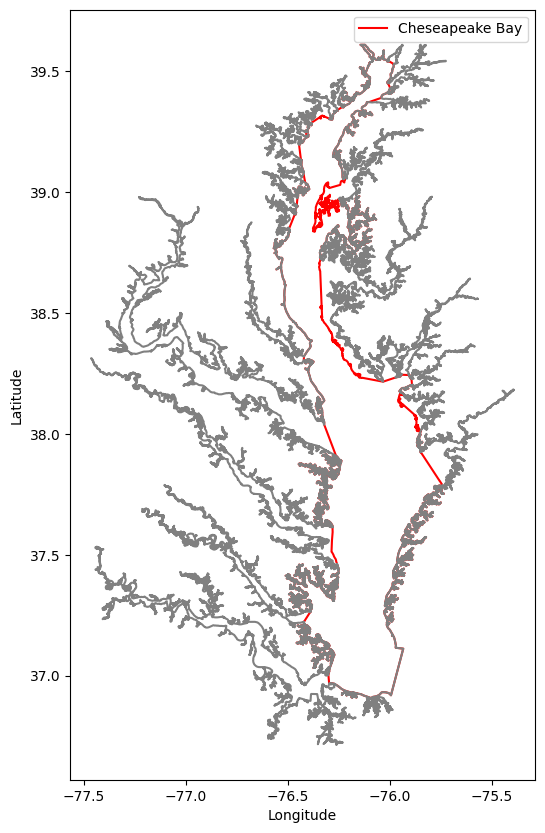

In [7]:
# Merge all polygons into a single geometry
bay_polygon = unary_union(filtered_gdf['geometry'])
watershed_polygon = unary_union(gdf['geometry']).buffer(0)


# Adjust the figure size (width, height)
plt.figure(figsize=(6,10))

# Plot the polygon
# Extract coordinates for filtered polygon (e.g., bay_polygon)
bay_x, bay_y = bay_polygon.exterior.xy
plt.plot(bay_x, bay_y, color='red', label='Cheseapeake Bay')

if watershed_polygon.geom_type == 'MultiPolygon':
    for poly in watershed_polygon.geoms:
        x, y = poly.exterior.xy
        plt.plot(x, y, color='grey')
# If it's a single Polygon, just plot it directly
elif watershed_polygon.geom_type == 'Polygon':
    x, y = watershed_polygon.exterior.xy
    plt.plot(x, y, color='grey')

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Show the plot
plt.show()

We also want a common way to name the regions and assign a salinity zone.

In [8]:
def assign_region_id(region):
    if region.startswith('CB'):
        region_number = int(re.search(r'(\d+)', region).group(1)) - 1
    elif region == "EASMH":
        region_number = 8
    elif region ==  "MOBPH":
        region_number = 9
    elif region == "TANMH":
        region_number = 10
    return region_number

def assign_salinity_zone(single_value):
    # Handle single value
    if isinstance(single_value, str):
        if single_value.endswith('TF'):
            return 0
        elif single_value.endswith('OH'):
            return 0.33
        elif single_value.endswith('MH'):
            return 0.67
        elif single_value.endswith('PH'):
            return 1
    return None

## Dealing with the latitude and longitude grid

We will need to create lat/lon grids several times, so here is the common function.

In [9]:
def create_lat_lon_grid(ds):
    # Vectorized grid creation
    lon_coords = ds['lon'].values  # Longitude coordinates
    lat_coords = ds['lat'].values  # Latitude coordinates
    lon_grid, lat_grid = np.meshgrid(lon_coords, lat_coords, indexing='xy')

    return lon_grid, lat_grid

The next step is creating a mask for the regional polygons. This mask will split the data set into 11 regional datasets

In [10]:
def regional_polygon_mask(ds, polygon):
    lon_grid, lat_grid = create_lat_lon_grid(ds)
    mask_2d = contains(polygon, lon_grid.flatten(), lat_grid.flatten()).reshape(lon_grid.shape)
    mask_expanded = xr.DataArray(mask_2d, dims=('lat', 'lon'), coords={'lat': ds['lat'], 'lon': ds['lon']})

    # create the actual masked region
    masked_ds = ds.where(mask_expanded, drop=True) 


    return masked_ds

We will also need to convert the latitude and longitude into a single float. This is done using the positions in the satelitte data in [Satelitte and buoy data/Masking dataset with shape file](#masking-datasets-with-shape-file). Here we will read in the dictionary and define other common functions to handle this process.

In [11]:
with open('../../data/filesForModel/tensors/umap_coord_dict.pkl', 'rb') as file:
    umap_coord_dict = pickle.load(file)

In [12]:
def create_map_umap(masked_ds, mapping_dict):
    # Initialize the array for UMAP values
    index_mapping ={}
    umap_values = []
    umap_value_to_index = {}
    time_indices = range(len(masked_ds['time'].values))

    for original_lat_lon_index in np.ndindex(masked_ds.dims['lat'], masked_ds.dims['lon']):

        lat_index = original_lat_lon_index[-2]
        lon_index = original_lat_lon_index[-1]

        # Retrieve latitude and longitude values in a single operation
        lat_value, lon_value = masked_ds['lat'].values[lat_index], masked_ds['lon'].values[lon_index]

        # Check if (lat, lon) exists in mapping_dict
        umap_value = mapping_dict.get((lat_value, lon_value))

        # If a valid UMAP value exists, store it and its index
        if umap_value is not None:
            # If the UMAP value is new, append to umap_values and assign index
            if umap_value not in umap_value_to_index:
                umap_values.append(umap_value)
                valid_index = len(umap_values) - 1
                umap_value_to_index[umap_value] = valid_index
            else:
                # Retrieve the existing index from the dictionary
                valid_index = umap_value_to_index[umap_value]

        for time_index in time_indices:
            original_index = (time_index, 0, lat_index, lon_index)
            index_mapping[original_index] = valid_index  # Store the mapping

    return umap_values, index_mapping

def create_1D_coords(masked_ds, mapping_dict):
    umap_values, index_mapping = create_map_umap(masked_ds, mapping_dict)

    new_data_shape = (masked_ds.dims['time'], int(len(umap_values)))  # use umap_values length
    new_ds = xr.Dataset()

    # for var in masked_ds.data_vars:
    for var in tqdm(masked_ds.data_vars, desc=f"Changing coordinates" , leave=False):
        new_data = np.full(new_data_shape, np.nan)

        masked_ds[var] = masked_ds[var].transpose('time', 'depth', 'lat', 'lon')

        original_values = masked_ds[var].values

        # Populate new_data using the precomputed index_map
        for key in index_mapping.keys():
            new_data[key[0], index_mapping[key]] = original_values[key]

        # Assign the new_data to the data variable with umap_coord as an additional dimension
        new_ds[var] = xr.DataArray(new_data, dims=('time','umap_coord'), coords={'time' : masked_ds['time'].values, 'umap_coord': umap_values})

    return new_ds


def add_lat_long_back(new_masked_ds, mapping_dict):
    umap_values = new_masked_ds['umap_coord'].values
    # Reverse the dictionary for umap_value to (lat, lon)
    umap_to_lat_lon = {umap_value: (lat, lon) for (lat, lon), umap_value in mapping_dict.items()}

    # Extract lat and lon values using vectorized approach (with NaN for missing values)
    lat_values, lon_values = zip(*[umap_to_lat_lon.get(umap_value, (np.nan, np.nan)) for umap_value in umap_values])
    lat_values = np.array(lat_values)
    lon_values = np.array(lon_values)

    # # Find min and max for lat and lon, ignoring NaNs
    # lat_min, lat_max = np.nanmin(lat_values), np.nanmax(lat_values)
    # lon_min, lon_max = np.nanmin(lon_values), np.nanmax(lon_values)

    # # Scale lat and lon to 0-1 range
    # lat_scaled = (lat_values - lat_min) / (lat_max - lat_min)
    # lon_scaled = (lon_values - lon_min) / (lon_max - lon_min)

    # Convert lat_values and lon_values into DataArrays and assign them to the xarray Dataset
    new_masked_ds = new_masked_ds.assign({
        'lat': xr.DataArray(lat_values, dims='umap_coord', coords={'umap_coord': umap_values}),
        'lon': xr.DataArray(lon_values, dims='umap_coord', coords={'umap_coord': umap_values})
    })

    new_masked_ds['lat'] = new_masked_ds['lat'].expand_dims({'time': new_masked_ds.time},axis=0)
    new_masked_ds['lon'] = new_masked_ds['lon'].expand_dims({'time': new_masked_ds.time},axis=0)

    # Verify that lat and lon have been added
    return new_masked_ds

Now we can convert the xarray to a pytorch tensor for use in the model.

In [13]:
def xarray_to_tensors(ds, exclude_var):
    included_vars = [var for var in ds.data_vars if var != exclude_var]

    # Convert all variables except the excluded one into a tensor
    data_arrays = [torch.tensor(ds[var].values,dtype=torch.float32) for var in ds.data_vars if var != exclude_var]

    # Stack the remaining tensors into one single tensor, adding a new dimension for the variables
    features_tensor = torch.stack(data_arrays, dim=1)
    features_tensor = torch.nan_to_num(features_tensor, nan=0.0)

    # Create a dictionary mapping variable names to their corresponding tensor slices
    variable_indeces = {included_vars[i]: i for i in range(features_tensor.shape[1])}

    # Extract time and position values, assuming these are dimensions in ds
    time_values = ds['time'].values  # Adjust this key based on your dataset
    position_values = ds['umap_coord'].values  # Adjust this key based on your dataset

    # Create dictionaries for time and position values
    time_dict = {i: time_values[i] for i in range(len(time_values))}
    position_dict = {i: position_values[i] for i in range(len(position_values))}


    # Chlorophyll data
    chlorophyll_tensor = torch.tensor(ds[exclude_var].values,dtype=torch.float32)
    chlorophyll_tensor = torch.nan_to_num(chlorophyll_tensor, nan=0.0)

    # For now, remove the depth dimension
    features_tensor = features_tensor.squeeze(1)
    chlorophyll_tensor = chlorophyll_tensor.squeeze(1)

    # Optional: Print shapes to confirm
    print(f"Features tensor shape: {features_tensor.shape}")
    print(f"Chlorophyll tensor shape: {chlorophyll_tensor.shape}")

    return features_tensor, chlorophyll_tensor, variable_indeces, time_dict, position_dict

In [14]:
import pickle

pickle.dump(umap_coord_dict, open('../../data/filesForModel/withDateFeatures/tensors/umap_coord_dict.pkl','wb'))

In [15]:
def process_data_for_tensor(data_region_dict, variable_to_exclude, umap_coord_dict, 
                            features_filename_template,       # Template for features file name
                            chlorophyll_filename_template,      # Template for chlorophyll file name
                            indices_file
):
    output_tensors_dict = {}  # Dictionary to temporarily hold region tensors
    tensor_indices_dict = {}
    
    for idx, region_data in data_region_dict.items():
        # Generate tensors and index dictionaries
        features_tensor, chlorophyll_tensor, variable_indices, time_dict, position_dict = xarray_to_tensors(region_data, variable_to_exclude)

        # Store tensors in a dictionary
        output_tensors_dict[f'region_{idx}'] = {
            "Features": features_tensor,
            "Chlorophyll": chlorophyll_tensor
        }
        
        # Store indices in a separate dictionary
        tensor_indices_dict[f'region_{idx}'] = {
            "Variables": variable_indices,
            "Times": time_dict,
            "Positions": position_dict
        }

        # Save tensors to files using provided file name templates and fixed path
        torch.save(features_tensor, f"../../data/filesForModel/tensors/{features_filename_template.format(idx)}")
        torch.save(chlorophyll_tensor, f"../../data/filesForModel/tensors/{chlorophyll_filename_template.format(idx)}")


    for region_key, region_data in tensor_indices_dict.items():
        updated_positions = {}
        
        for pos_key, pos_value in region_data["Positions"].items():
            # Find the (lat, lon) tuple corresponding to the float position value
            for (lat, lon), position in umap_coord_dict.items():
                if pos_value == position:
                    updated_positions[pos_key] = (lat, lon)  # Replace with (lat, lon) tuple
                    break  # Exit the loop once a match is found
            else:
                # If no match found, retain the original value (or handle as needed)
                updated_positions[pos_key] = pos_value 

        # Update the Positions in the region data
        region_data["Positions"] = updated_positions

    pickle.dump(tensor_indices_dict, open(f'../../data/filesForModel/tensors/{indices_file}.pk', 'wb'))

    return output_tensors_dict, tensor_indices_dict


# Satelitte and buoy data

## Preparing the satellite data

We will read in the satellite data as an xarray. This data has coordinates

>Coordinates:
>  * x        (x)  
>  * y        (y)  
>  *  lat      (y, x)
>  *  lon      (y, x)
>  * time     (time)
>  * level    (level)

where `x` is projection_x_coordinate in meters, `y` is projection_y_coordinate in meters, `lat` is latitude, `lon` is longitude, `time` is a `datetime64` timestamp, and `level` is the height of the measurement from the surface. All `level` values are `0`, indicating surface measurements.

We do not need two set of location coordinates, so we will regrid the data to use `lat` and `lon` as the coordinate variables. This will match with the coordinates from our other datasets. We will also rename `level` to `depth`.

In [10]:
satellite_data = xr.open_dataset('../../data/combinedSatelitte_unmasked.nc4')

satellite_data

In [11]:
plt.figure(figsize=(6, 10))

# Calculate the mean across the time dimension for the current variable
variable_mean = satellite_data['chlor_a'].max(dim='time', skipna=True).isel(level=0)

# Plot the variable using xarray
variable_mean.plot(cmap='viridis')

# Add labels and title
plt.title('Chlorophyll Concentration (original)')
plt.xlabel('Projected_x')
plt.ylabel('Projected_y')

# Show the plot
plt.show()

In [12]:
def xarray_select_variables(ds):

    latitude = ds['lat'].values
    longitude = ds['lon'].values

    spatial_dims = ('y', 'x')

    # Stack the 'chlor_a' variable based on detected spatial dimensions and get the flattened array
    var_flat = ds['chlor_a'].stack(spatial=spatial_dims).values


    # Remove duplicate lat/lon points to ensure unique lat/lon coordinates if needed
    lat_unique, lon_unique = np.unique(latitude)[::-1], np.unique(longitude)

    # Rename level
    ds = ds.rename({'level':'depth'})

    # Initialize the new dataset with reshaped data
    new_ds = xr.Dataset(
        {
            'chlor_a': (('time', 'depth', 'lat', 'lon'), var_flat.reshape(ds['time'].size, ds['depth'].size, len(lat_unique), len(lon_unique)))
        },
        coords={
            'time': ds['time'],
            'depth': ds['depth'],
            'lat': lat_unique,
            'lon': lon_unique
        }
    )

    # Step 6: Dynamically copy metadata for all data variables
    for var in ds.data_vars:
        # Check if the variable exists in the new dataset and copy metadata
        if var in new_ds.data_vars:
            new_ds[var].attrs = ds[var].attrs  # Copy the metadata dynamically

    # Step 7: Dynamically copy metadata for all coordinates (no hardcoding)
    for coord in ds.coords:
        # If the coordinate exists in the new dataset, copy metadata
        if coord in new_ds.coords:
            new_ds[coord].attrs = ds[coord].attrs

    new_ds['lat'].attrs = ds['lat'].attrs  # Copy longitude metadata

    new_ds['lon'].attrs = ds['lon'].attrs  # Copy longitude metadata

    new_ds.attrs = ds.attrs

    # Check the new dataset structure
    return new_ds


In [13]:
satellite_data_reindex= xarray_select_variables(satellite_data)
satellite_data_reindex

In [14]:
plt.figure(figsize=(6, 10))

# Calculate the mean across the time dimension for the current variable
variable_mean = satellite_data_reindex['chlor_a'].max(dim='time', skipna=True).isel(depth=0)

# Plot the variable using xarray
variable_mean.plot(cmap='viridis')

# Add labels and title
plt.title('Chlorophyll Concentration (reindex)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [15]:
for var in satellite_data_reindex.data_vars:
    data = satellite_data_reindex[var]
    total_values = np.prod(data.shape)
    nan_values = np.isnan(data).sum().item()
    percent_nan = (nan_values / total_values) * 100
    print(f"Percentage of NaN values in '{var}': {percent_nan:.2f}%")

## Preparing the buoy data

### Read and clean the dataset

In [ ]:
# read in Jun's buoy data
buoy_df = pd.read_csv('../../data/plank_ChesapeakeBay_all_buoys.csv')
buoy_timestamped = process_buoy_datetime(buoy_df, 'Sample_year', 'Sample_month', 'Sample_day', 'Sample_hour', 'Sample_minute', 'Sample_second')

The buoy data also contains columns with `QC` that describe the quality of the reading. Since we do not need that information, let's drop those columns.

In [ ]:
buoy_timestamped = buoy_timestamped.loc[:, ~buoy_timestamped.columns.str.contains('QC')]

There were also some issues with the way the data was combined, let's fix that.

In [ ]:
buoy_timestamped = buoy_timestamped.drop(columns=['Latitude_y','Longitude_y'])


In [ ]:
start_date = pd.to_datetime(satellite_data_reindex['time'].min().item())
end_date = pd.to_datetime(satellite_data_reindex['time'].max().item())

buoy_timestamped = buoy_timestamped[(buoy_timestamped['timestamp'] >= start_date) & (buoy_timestamped['timestamp'] <= end_date)]

And some more cleaning to remove invalid latitude and longitude measurements.

In [ ]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(buoy_data):
    # Filter rows based on column: 'Longitude_x'
    buoy_data = buoy_data[(buoy_data['Longitude_x'].notna()) & (buoy_data['Longitude_x'] < -70) & (buoy_data['Longitude_x'] > -80)]
    # Filter rows based on column: 'Latitude_x'
    buoy_data = buoy_data[(buoy_data['Latitude_x'].notna()) & (buoy_data['Latitude_x'] > 35) & (buoy_data['Latitude_x'] < 40)]
    # Rename column 'Latitude_x' to 'Latitude'
    buoy_data = buoy_data.rename(columns={'Latitude_x': 'Latitude','Longitude_x': 'Longitude'})
    return buoy_data

buoy_data_clean = clean_data(buoy_timestamped.copy())
buoy_data_clean.columns

The next step is preparing the data to align with our satellite data.  Since the buoys move a bit, the latitude and longitude values should be rounded before aggregation. The satellite data uses two decimal places, and that should also be reasonable for the buoy data.Since the buoy data is taken every 6-60 minutes, depending on the parameter, and the satellite data is roughly daily, we will use the daily mean measurements.

In [ ]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(buoy_data_clean):
    # Round column 'Latitude' (Number of decimals: 2)
    buoy_data_clean = buoy_data_clean.round({'Latitude': 2})
    # Round column 'Longitude' (Number of decimals: 2)
    buoy_data_clean = buoy_data_clean.round({'Longitude': 2})
    return buoy_data_clean

buoy_data_rounded = clean_data(buoy_data_clean.copy())
buoy_data_rounded.head()

In [ ]:
# Assuming buoy_data is your DataFrame
# buoy_data_rounded['timestamp'] = pd.to_datetime(buoy_data_rounded['timestamp'])  # Convert to datetime if not already
buoy_data_rounded.set_index('timestamp', inplace=True)  # Set the timestamp as the index

# Group by date and latitude/longitude, aggregating measurement columns
daily_aggregate = (
    buoy_data_rounded.groupby([buoy_data_rounded.index.date, 'Latitude', 'Longitude'])
    .agg('mean')  # Default behavior is to calculate the mean, ignoring NaNs
    .reset_index()
)

# Rename the date column for clarity
daily_aggregate.rename(columns={'level_0': 'Date'}, inplace=True)


Finally, we will only retain parameters with data in at least 10% of the rows.

In [ ]:
# threshold = 0.1
threshold = 0.3

missing_percentage = daily_aggregate.isnull().mean()

columns_to_keep = missing_percentage[missing_percentage <= threshold].index

# Create a new DataFrame with only the columns to keep
daily_aggregate = daily_aggregate[columns_to_keep]

print('Remaining columns:', daily_aggregate.columns)

In [ ]:
daily_aggregate.dtypes

Now we can save this aggregated data in a CSV to access later.

In [ ]:
daily_aggregate.to_csv('../../data/buoy_aggregate.csv', index=False)

### Aggregate by date

We will read in the buoy data, then create a dictionary that aggreates the data by day. This dictionary will save time when aligning with the satellite data, as the grouping csv rows takes time.

In [16]:
buoy_data= pd.read_csv('../../data/buoy_aggregate.csv')


buoy_data['Date'] = pd.to_datetime(buoy_data['Date'])
buoy_data.columns

Now we need to group the rows by date so that we can merge with the corresponding satellite data.

In [17]:
def preprocess_dataframe_by_date(df):
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    # Group DataFrame by date
    start_date = pd.to_datetime(satellite_data_reindex['time'].min().item()).date()
    end_date = pd.to_datetime(satellite_data_reindex['time'].max().item()).date()

    restricted_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

    grouped_data = {date: group for date, group in restricted_df.groupby('Date')}
    return grouped_data

buoy_dates_dict = preprocess_dataframe_by_date(buoy_data)

Now we can restrict our dataset to the dates that our in our satellite data.

## Combining into one xarray

We need to to add the variables from the buoy data to the satellite data. First, we will find the buoy data for the correct date. Then, for each location in the the xarray, we find the closest buoy and attach the daily mean measurement for each of the variables.

Since we already filtered the chlorophyll data to only the Chesapeake Bay, we will use `chlor_a` to create a mask.

In [6]:
def merge_and_clean_xarray(ds, grouped_data):
    try:
        # Chunk the dataset using Dask, allowing lazy evaluation
        ds = ds.chunk({'time': 1, 'lat': 50, 'lon': 50})  # Adjust chunk sizes based on your memory

        # Extract latitude and longitude values
        latitudes = ds['lat'].values
        longitudes = ds['lon'].values
        times = ds['time'].values

        # Create a 2D meshgrid of lat/lon for the xarray data
        lat_grid, lon_grid = np.meshgrid(latitudes, longitudes, indexing='ij')
        points = np.column_stack((lat_grid.ravel(), lon_grid.ravel()))  # Xarray lat/lon pairs

        new_ds_list = []

        # Process each time value in the dataset
        for time_value in tqdm(ds['time'].values, desc="Processing time steps", leave=False):
            # Extract date for each time value
            date_value = pd.to_datetime(time_value, unit='s').date()
                
            if date_value not in grouped_data:
                continue

            df_filtered = grouped_data[date_value]

            # Extract latitude and longitude from the filtered CSV data
            csv_lat = df_filtered['Latitude'].values
            csv_lon = df_filtered['Longitude'].values
            csv_points = np.column_stack((csv_lat, csv_lon))  # CSV lat/lon points

            # Perform interpolation for all variables at once (excluding lat, lon, Date, Humidity)
            variables_to_interpolate = df_filtered.columns.difference(['Latitude', 'Longitude', 'Date', 'Humidity'])
            interpolated_data = {}

            # Vectorize the interpolation using RBFInterpolator for all variables at once
            for var in variables_to_interpolate:
                values = df_filtered[var].values
                
                if np.all(np.isnan(df_filtered[var].values)):
                    nan_array = np.full(lat_grid.shape, np.nan)
                    interpolated_data[var] = da.from_array(nan_array, chunks=(50, 50))

                else:
                    # Remove NaN values
                    valid_mask = ~np.isnan(values)
                    valid_points = csv_points[valid_mask]
                    valid_values = values[valid_mask]

                    # Create the interpolator with valid data only
                    interpolator = RBFInterpolator(valid_points, valid_values, kernel='linear')
                    interpolated_values = da.from_array(interpolator(points).reshape(lat_grid.shape), chunks=(50, 50))
                    interpolated_data[var] = interpolated_values
                    

            new_ds = ds.copy(deep=True)


            # Assign interpolated values to the new dataset
            for var, data in interpolated_data.items():
                new_ds[var] = xr.DataArray(
                    data[np.newaxis,np.newaxis, :, :],  # Add time dimension
                    dims=('time', 'depth', 'lat', 'lon'),
                    coords={'time': [date_value], 'depth': [0], 'lat': latitudes, 'lon': longitudes}
                )


            new_ds_list.append(new_ds)

        batch_size = 100
        merged_batches = []

        # Process each batch with Dask's delayed execution
        for i in tqdm(range(0, len(new_ds_list), batch_size),desc="Processing batches", leave=False):
            batch = new_ds_list[i:i + batch_size]
            # Use dask.delayed to parallelize the concatenation of each batch
            delayed_batch = delayed(xr.concat)(batch, dim='time')
            merged_batches.append(delayed_batch)

        # Now use Dask to concatenate the delayed batches in parallel
        final_merged_ds = delayed(xr.concat)(merged_batches, dim='time')
    
    except Exception as e:
        raise RuntimeError(f"Error merging and cleaning xarray: {str(e)}")

    # Perform computation with Dask
    return final_merged_ds.compute()


In [18]:
merged_data = merge_and_clean_xarray(satellite_data_reindex,buoy_dates_dict)

In [46]:
def calculate_percent_nan(ds):
    for var in ds.data_vars:
        data = ds[var]
        total_values = np.prod(data.shape)
        nan_values = np.isnan(data).sum().item()
        percent_nan = (nan_values / total_values) * 100
        print(f"Percentage of NaN values in '{var}': {percent_nan:.2f}%")


In [34]:
merged_data.to_netcdf('../../data/satelliteBuoy_merged.nc4')

## Dealing with missing values

In [52]:
merged_data = xr.open_dataset('../../data/satelliteBuoy_merged.nc4')


We will check how many values are missing, and thhen interpolate to fill in missing valures. Since the only missing data is for chlorphyll, we only need to interpolate the chlorophyll data.

In [53]:
cleaned_data = merged_data

cleaned_data['chlor_a'] = cleaned_data['chlor_a'].interpolate_na(dim='time', method='linear')

Finally, we normalize the data. We scale the weather data to be between 0 and 1. Let's check the statistics for the variables.

In [54]:
# List of features to normalize (excluding the target 'chlor_a')
variables_to_normalize = ['Air Temperature', 'Air pressure', 'Wind speed', 'Wind Direction']

for var in variables_to_normalize:
    # Compute the min and max values across time, depth, lat, and lon
    var_min = cleaned_data[var].min(dim=('time', 'depth', 'lat', 'lon'))
    var_max = cleaned_data[var].max(dim=('time', 'depth', 'lat', 'lon'))

    # Apply min-max scaling
    cleaned_data[var] = (cleaned_data[var] - var_min) / (var_max - var_min)

We can also plot the chlorophyll values to determine the best way to scale the data.

Trying a log transformation

(array([  98814., 2707596., 5808551., 5730887., 5177729., 4633222.,
        4409121., 4087573., 3691681., 3382240., 3117483., 2935551.,
        2794891., 2730476., 2646243., 2474166., 2246923., 2033869.,
        1870285., 1725888., 1600082., 1506378., 1436481., 1384002.,
        1339648., 1291095., 1252565., 1228361., 1194920., 1128797.,
        1039934.,  957650.,  879433.,  820297.,  749845.,  687906.,
         627042.,  553972.,  476178.,  410742.,  365883.,  327320.,
         297694.,  271994.,  240786.,  214629.,  184087.,  144189.,
          99262.,   51943.]),
 array([0.        , 0.10679717, 0.21359435, 0.32039151, 0.42718869,
        0.53398585, 0.64078301, 0.74758017, 0.85437739, 0.96117455,
        1.06797171, 1.17476892, 1.28156602, 1.38836324, 1.49516034,
        1.60195756, 1.70875478, 1.81555188, 1.9223491 , 2.02914619,
        2.13594341, 2.24274063, 2.34953785, 2.45633483, 2.56313205,
        2.66992927, 2.77672648, 2.8835237 , 2.99032068, 3.0971179 ,
        3.20391512

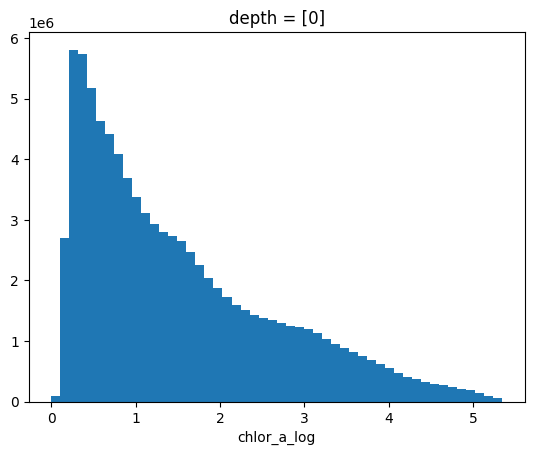

In [55]:
# Apply log transformation to chlor_a, adding 1 to avoid log(0)
cleaned_data['chlor_a_log'] = np.log(cleaned_data['chlor_a'] + 1)

# Check the distribution after the transformation
cleaned_data['chlor_a_log'].plot.hist(bins=50)


(array([1779752., 1691579., 1757748., 1598370., 1781386., 1641315.,
        1743390., 1809058., 1758793., 1743901., 1634107., 1604149.,
        1853826., 1857907., 2070890., 1812963., 1696610., 1853065.,
        1735944., 1654539., 1529976., 1643258., 1555437., 1797410.,
        1887652., 1749171., 1864384., 1826907., 1669528., 1823059.,
        1651623., 1699386., 1541749., 1805752., 1536702., 1899898.,
        1727661., 1810284., 1646439., 1845034., 1535315., 1771575.,
        1822714., 1828229., 1851257., 1737609., 1555317., 1683476.,
        2043466., 1646744.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

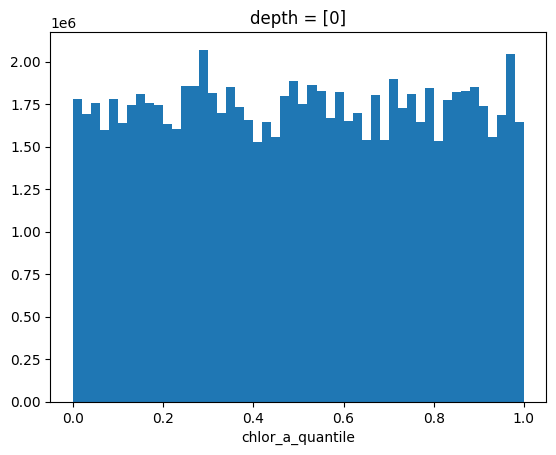

In [56]:

# Extract chlor_a values and flatten the data, remove NaN values
chlor_a_values = cleaned_data['chlor_a'].values.flatten()
chlor_a_values = chlor_a_values[~np.isnan(chlor_a_values)]  # Remove NaN values

# Reshape the data to a 2D array (required by QuantileTransformer)
chlor_a_values = chlor_a_values.reshape(-1, 1)

# Apply quantile transformation to map the data to a uniform distribution
quantile_transformer = QuantileTransformer(output_distribution='uniform', n_quantiles=1000, random_state=0)
chlor_a_quantile = quantile_transformer.fit_transform(chlor_a_values)

# Reshape the transformed data back to the original chlor_a shape
chlor_a_quantile_reshaped = np.full(cleaned_data['chlor_a'].shape, np.nan)
chlor_a_quantile_reshaped[~np.isnan(cleaned_data['chlor_a'].values)] = chlor_a_quantile.flatten()

# Add transformed data back into the xarray dataset
cleaned_data['chlor_a_quantile'] = (('time', 'depth', 'lat', 'lon'), chlor_a_quantile_reshaped)

cleaned_data['chlor_a_quantile'].plot.hist(bins=50)


In [57]:
cleaned_data['chlor_a'] = cleaned_data['chlor_a_quantile']
cleaned_data = cleaned_data.drop_vars(['chlor_a_quantile','chlor_a_log'])

In [58]:
from sklearn.preprocessing import QuantileTransformer
import joblib

# Assume quantile_transformer is your trained transformer
joblib.dump(quantile_transformer, '../../data/filesForModel/quantile_transformer.pkl')


['../../data/filesForModel/quantile_transformer.pkl']

In [59]:
chlor_a_min = cleaned_data['chlor_a'].min()
chlor_a_max = cleaned_data['chlor_a'].max()
chlor_a_range = (chlor_a_min, chlor_a_max)
chlor_a_range


(<xarray.DataArray 'chlor_a' ()> Size: 8B
 array(0.),
 <xarray.DataArray 'chlor_a' ()> Size: 8B
 array(1.))

In [60]:
cleaned_data.to_netcdf('../../data/satelliteBuoy_clean.nc4')

## Masking datasets with shape file

We only want to work with data from the Chesapeake Bay proper. Additionally, for latitude and longitude points corresponding to land instead of water, the chlorophyll value is always set to `-1`, which will create false correlations in the analysis.

Skipping the previous sections by reading in the file

In [61]:
cleaned_data = xr.open_dataset('../../data/satelliteBuoy_clean.nc4')


We will combine the latitude and longitude coordinates into one `position` coordinate. This will make it easier to restrict the data to the latitude and longitude points inside the Bay. We need to make sure this is done in a unique way, but we need a 1D representation that can be fed into our tensors.

Here we create the dictionary between the 2D (lat, lon) and a 1D float, using the `umap` package.

In [62]:
# import umap
def flatten_points_dict(ds):
    # Create a meshgrid of lat and lon
    lon_grid, lat_grid = create_lat_lon_grid(ds)

    # Flatten the meshgrid into coordinate pairs (for xarray points)
    lat_lon_grid = np.column_stack((lat_grid.ravel(), lon_grid.ravel()))  # Xarray lat/lon pairs

    # Initialize UMAP model with verbose=True to track progress
    umap_model = umap.UMAP(n_components=1)

    # Fit and transform the data
    embedding = umap_model.fit_transform(lat_lon_grid).flatten()

    mapping = {tuple(lat_lon_grid[i]): embedding[i] for i in range(lat_lon_grid.shape[0])}

    return mapping

In [63]:
# umap_coord_dict= flatten_points_dict(cleaned_data)
# pickle.dump(umap_coord_dict, open('../../data/filesForModel/tensors/umap_coord_dict.pkl','wb'))

with open('../../data/filesForModel/tensors/umap_coord_dict.pkl', 'rb') as file:
    umap_coord_dict = pickle.load(file)


In [64]:
def satbuoy_coord_change(ds_dict, mapping_dict):
    masked_xarrays = {}  # Dictionary to store individual region xarrays

    # Initialize tqdm progress bar with a total count based on filtered_gdf
    with tqdm(total=len(ds_dict), desc="Creating xarrays regions") as outer_pbar:
        for idx, row in filtered_gdf.iterrows():
            with tqdm(total=3, desc=f"Processing region", leave=False) as inner_pbar:
                region_id = row['CBSEG_92']
                salinity_zone = assign_salinity_zone(row['CBSEG_92'])  # Assign Salinity Zone

                masked_ds = ds_dict[region_id]

                # umap_values = umap_dict[region_id]['umap values']
                # index_mapping = umap_dict[region_id]['index mapping']
                new_coordinates_ds = create_1D_coords(masked_ds, mapping_dict)
                inner_pbar.update(2)

                valid_mask = new_coordinates_ds.notnull().any(dim='time')  # This creates a boolean mask for umap_coord

                new_masked_ds = new_coordinates_ds.where(valid_mask, drop=True)

                salinity_zone_array = xr.DataArray(
                    salinity_zone * np.ones_like(new_masked_ds['chlor_a'].values),  # Assume a variable like chlor_a for shape
                    dims=('time', 'umap_coord'),
                    coords={'time': new_masked_ds['time'], 'umap_coord': new_masked_ds['umap_coord']}
                )

                new_masked_ds = new_masked_ds.assign({'Salinity_Zone': salinity_zone_array})

                new_masked_ds = add_lat_long_back(new_masked_ds,mapping_dict)

                # Add metadata as attributes
                new_masked_ds.attrs.update({
                    'State': row['STATE'],
                    'BasinGroup': row['BasinGroup'],
                    'Name': row['Name'],
                    'CBSeg2003': region_id
                })

                masked_xarrays[region_id] = new_masked_ds

                print(f"xarray for {region_id}: {new_masked_ds.dims} ")
                inner_pbar.update(1)  # Progress for adding xarray

                outer_pbar.update(1)
    return masked_xarrays  # Return list of masked xarrays for each reg


In [65]:
filtered_gdf = gdf[
    (gdf['CBSEG_92'].astype(str).str.startswith('CB')) |
    (gdf['CBSEG_92'] == 'EASMH') |
    (gdf['CBSEG_92'] == 'MOBPH') |
    (gdf['CBSEG_92'] =='TANMH')
]
masked_grids_dict ={
    region: regional_polygon_mask(cleaned_data, polygon)
    for region, polygon in filtered_gdf_dict.items()
}

In [ ]:
masked_xarrays = satbuoy_coord_change(masked_grids_dict, umap_coord_dict)

In [67]:
masked_xarrays['CB1TF']

<xarray.Dataset> Size: 22MB
Dimensions:          (time: 2764, umap_coord: 127)
Coordinates:
  * time             (time) datetime64[ns] 22kB 2014-08-28T17:55:08 ... 2022-...
  * umap_coord       (umap_coord) float32 508B -10.86 -10.89 ... -9.417 -9.453
Data variables:
    chlor_a          (time, umap_coord) float64 3MB nan nan nan ... nan nan nan
    Air Temperature  (time, umap_coord) float64 3MB 0.3518 0.3517 ... 0.2847
    Air pressure     (time, umap_coord) float64 3MB 0.1395 0.1394 ... 0.1091
    Wind Direction   (time, umap_coord) float64 3MB 0.7632 0.7668 ... 0.5513
    Wind speed       (time, umap_coord) float64 3MB 0.1561 0.1561 ... 0.1331
    Salinity_Zone    (time, umap_coord) float64 3MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lat              (time, umap_coord) float64 3MB 39.6 39.59 ... 39.41 39.41
    lon              (time, umap_coord) float64 3MB -76.12 -76.11 ... -76.02
Attributes:
    State:       MD
    BasinGroup:  MD MAIN
    Name:        Northern Chesapeake Bay
    CBSeg2003:   CB1TF

In [69]:
for region, region_data in tqdm(masked_xarrays.items(),leave=False):
    index = assign_region_id(region)
    region_data.to_netcdf(f'../../data/filesForModel/noDateFeatures/nc4/satelliteBuoy_region{index}.nc4')

  0%|          | 0/11 [00:00<?, ?it/s]

## Prepare to feed into the model

In [70]:
# satellite_buoy = masked_xarray
#or if you skipped previous section
# satellite_buoy = xr.open_dataset('../../data/satelliteBuoy_clean_masked.nc4')
satellite_buoy_dict= {}
for i in range(11):
    region_data = xr.open_dataset(f"../../data/filesForModel/noDateFeatures/nc4/satelliteBuoy_region{i}.nc4")
    satellite_buoy_dict[i]= region_data

Now we can convert the xarray to a pytorch tensor for use in the model.

In [71]:
def xarray_to_tensors(ds, exclude_var):
    included_vars = [var for var in ds.data_vars if var != exclude_var]

    exclude_var = 'chlor_a'  
    included_vars = [var for var in ds.data_vars if var != exclude_var]

    # Convert all variables except the excluded one into a tensor
    data_arrays = [torch.tensor(ds[var].values,dtype=torch.float32) for var in ds.data_vars if var != exclude_var]

    # Stack the remaining tensors into one single tensor, adding a new dimension for the variables
    features_tensor = torch.stack(data_arrays, dim=1)

    # Create a dictionary mapping variable names to their corresponding tensor slices
    variable_indeces = {included_vars[i]: i for i in range(features_tensor.shape[1])}

    # Extract time and position values, assuming these are dimensions in ds
    time_values = ds['time'].values 
    position_values = ds['umap_coord'].values  

    # Create dictionaries for time and position values
    time_dict = {i: time_values[i] for i in range(len(time_values))}
    position_dict = {i: position_values[i] for i in range(len(position_values))}


    # Chlorophyll data
    cleaned_chlorophyll_data = ds[exclude_var].fillna(0)  # Replace NaNs with 0, or use another method

    chlorophyll_tensor = torch.tensor(cleaned_chlorophyll_data.values, dtype=torch.float32)

    # For now, remove the depth dimension
    features_tensor = features_tensor.squeeze(1)
    chlorophyll_tensor = chlorophyll_tensor.squeeze(1)

    # Optional: Print shapes to confirm
    print(f"Features tensor shape: {features_tensor.shape}")
    print(f"Chlorophyll tensor shape: {chlorophyll_tensor.shape}")

    return features_tensor, chlorophyll_tensor, variable_indeces, time_dict, position_dict

In [72]:
def create_tensors_and_dict(xarray_dict, indices_dict_file_pattern):
    tensors_dict = {}
    tensor_indices_dict = {}
    for index, region_data in xarray_dict.items():
        # index = assign_region_id(region)
        features_tensor, chlorophyll_tensor, variable_indeces, time_dict, position_dict = xarray_to_tensors(region_data,'chlor_a')
        tensors_dict[f'region_{index}'] = {"Features": features_tensor,
                                                        "Chlorophyll": chlorophyll_tensor}
        tensor_indices_dict[f'region_{index}'] = {"Variables": variable_indeces,
                                                "Times": time_dict,
                                                "Positions": position_dict}


            # Update the Positions in each region
    for region_id, region_data in tensor_indices_dict.items():
        updated_positions = {}
        
        for pos_key, pos_value in region_data["Positions"].items():
            # Find the (lat, lon) tuple corresponding to the float position value
            for (lat, lon), position in umap_coord_dict.items():
                if pos_value == position:
                    updated_positions[pos_key] = (lat, lon)  # Replace with (lat, lon) tuple
                    break  # Exit the loop once a match is found
            else:
                # If no match found, retain the original value (or handle as needed)
                updated_positions[pos_key] = pos_value 

        # Update the Positions in the region data
        region_data["Positions"] = updated_positions
        
        torch.save(tensor_indices_dict, indices_dict_file_pattern)
        

    return tensors_dict

In [73]:
indices_file_pattern = '../../data/filesForModel/noDateFeatures/tensors/tensor_indices_dict.pt'
satbuoy_tensor_dict = create_tensors_and_dict(satellite_buoy_dict, indices_file_pattern)
for region, tensor_dict in satbuoy_tensor_dict.items():
    features = tensor_dict['Features']
    chloropyll = tensor_dict['Chlorophyll']
    torch.save(features, f"../../data/filesForModel/noDateFeatures/tensors/features_{region}_tensor.pt")
    torch.save(chloropyll, f"../../data/filesForModel/noDateFeatures/tensors/chlorophyll_{region}_tensor.pt")

Features tensor shape: torch.Size([2764, 7, 127])
Chlorophyll tensor shape: torch.Size([2764, 127])
Features tensor shape: torch.Size([2764, 7, 236])
Chlorophyll tensor shape: torch.Size([2764, 236])
Features tensor shape: torch.Size([2764, 7, 311])
Chlorophyll tensor shape: torch.Size([2764, 311])
Features tensor shape: torch.Size([2764, 7, 769])
Chlorophyll tensor shape: torch.Size([2764, 769])
Features tensor shape: torch.Size([2764, 7, 1234])
Chlorophyll tensor shape: torch.Size([2764, 1234])
Features tensor shape: torch.Size([2764, 7, 602])
Chlorophyll tensor shape: torch.Size([2764, 602])
Features tensor shape: torch.Size([2764, 7, 1251])
Chlorophyll tensor shape: torch.Size([2764, 1251])
Features tensor shape: torch.Size([2764, 7, 335])
Chlorophyll tensor shape: torch.Size([2764, 335])
Features tensor shape: torch.Size([2764, 7, 195])
Chlorophyll tensor shape: torch.Size([2764, 195])
Features tensor shape: torch.Size([2764, 7, 283])
Chlorophyll tensor shape: torch.Size([2764, 28

Let's also add year, month, and day of the year as paramenters, since there is seasonal variation. 

In [74]:
def expand_dates_and_normalize(xarray_dict):
    date_expanded_dict ={}
    for region, region_data in xarray_dict.items():
        ds = region_data.copy()  # Create a copy to avoid modifying in place

        # Extract year, month, and day_of_year from the time coordinate
        years = ds['time'].dt.year
        months = ds['time'].dt.month
        day_of_year = ds['time'].dt.dayofyear

        # Expand each variable to have dimensions (time, depth, lat, lon)
        # You can use xarray's broadcasting feature by adding new dimensions with expand_dims
        year_expanded = xr.DataArray(years, dims="time").expand_dims({'umap_coord' : ds.umap_coord},axis=1)
        month_expanded = xr.DataArray(months, dims="time").expand_dims({'umap_coord' : ds.umap_coord},axis=1)
        day_of_year_expanded = xr.DataArray(day_of_year, dims="time").expand_dims({'umap_coord' : ds.umap_coord},axis=1)

        # Add these as new data variables in the dataset
        ds['year'] = year_expanded
        ds['month'] = month_expanded
        ds['day_of_year'] = day_of_year_expanded
        
        # # Normalize year, month, day, lat, and lon
        # variables_to_normalize = ['year', 'month', 'day_of_year']

        # for var in variables_to_normalize:
        #     # Compute the min and max values across time, depth, lat, and lon
        #     var_min = ds[var].min(dim=('time', 'umap_coord'))
        #     var_max = ds[var].max(dim=('time', 'umap_coord'))

        #     # Apply min-max scaling
        #     ds[var] = (ds[var] - var_min) / (var_max - var_min)
        
        date_expanded_dict[region] = ds

    return date_expanded_dict


In [75]:
satbuoy_date_expanded_dict = expand_dates_and_normalize(satellite_buoy_dict)

for region, region_data in satbuoy_date_expanded_dict.items():
    # index = assign_region_id(region)
    region_data.to_netcdf(f'../../data/filesForModel/withDateFeatures/nc4/satelliteBuoy_{region}.nc4')

In [100]:
satbuoy_date_expanded_dict[0]

<xarray.Dataset> Size: 31MB
Dimensions:          (time: 2764, umap_coord: 127)
Coordinates:
  * time             (time) datetime64[ns] 22kB 2014-08-28T17:55:08 ... 2022-...
  * umap_coord       (umap_coord) float32 508B -10.86 -10.89 ... -9.417 -9.453
Data variables:
    chlor_a          (time, umap_coord) float64 3MB ...
    Air Temperature  (time, umap_coord) float64 3MB 0.3518 0.3517 ... 0.2847
    Air pressure     (time, umap_coord) float64 3MB 0.1395 0.1394 ... 0.1091
    Wind Direction   (time, umap_coord) float64 3MB 0.7632 0.7668 ... 0.5513
    Wind speed       (time, umap_coord) float64 3MB 0.1561 0.1561 ... 0.1331
    Salinity_Zone    (time, umap_coord) float64 3MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lat              (time, umap_coord) float64 3MB 39.6 39.59 ... 39.41 39.41
    lon              (time, umap_coord) float64 3MB -76.12 -76.11 ... -76.02
    year             (time, umap_coord) int64 3MB 2014 2014 2014 ... 2022 2022
    month            (time, umap_coord) int64 3MB 8 8 8 8 8 8 ... 10 10 10 10 10
    day_of_year      (time, umap_coord) int64 3MB 240 240 240 ... 303 303 303
Attributes:
    State:       MD
    BasinGroup:  MD MAIN
    Name:        Northern Chesapeake Bay
    CBSeg2003:   CB1TF

In [101]:
indices_file_pattern = '../../data/filesForModel/withDateFeatures/tensors/tensor_indices_dict.pt'
satbuoy_dates_tensor_dict = create_tensors_and_dict(satbuoy_date_expanded_dict, indices_file_pattern)

for region, tensor_dict in satbuoy_dates_tensor_dict.items():
    features = tensor_dict['Features']
    chloropyll = tensor_dict['Chlorophyll']
    torch.save(features, f"../../data/filesForModel/withDateFeatures/tensors/features_{region}_tensor.pt")
    torch.save(chloropyll, f"../../data/filesForModel/withDateFeatures/tensors/chlorophyll_{region}_tensor.pt")

Features tensor shape: torch.Size([2764, 10, 127])
Chlorophyll tensor shape: torch.Size([2764, 127])
Features tensor shape: torch.Size([2764, 10, 236])
Chlorophyll tensor shape: torch.Size([2764, 236])
Features tensor shape: torch.Size([2764, 10, 311])
Chlorophyll tensor shape: torch.Size([2764, 311])
Features tensor shape: torch.Size([2764, 10, 769])
Chlorophyll tensor shape: torch.Size([2764, 769])
Features tensor shape: torch.Size([2764, 10, 1234])
Chlorophyll tensor shape: torch.Size([2764, 1234])
Features tensor shape: torch.Size([2764, 10, 602])
Chlorophyll tensor shape: torch.Size([2764, 602])
Features tensor shape: torch.Size([2764, 10, 1251])
Chlorophyll tensor shape: torch.Size([2764, 1251])
Features tensor shape: torch.Size([2764, 10, 335])
Chlorophyll tensor shape: torch.Size([2764, 335])
Features tensor shape: torch.Size([2764, 10, 195])
Chlorophyll tensor shape: torch.Size([2764, 195])
Features tensor shape: torch.Size([2764, 10, 283])
Chlorophyll tensor shape: torch.Size

# Water Quality Dataset


## Read and clean water
For the water quality data, we will read in the CSV, drop columns that are not needed for the model. Let's drop the columns related to how the data was collected: `TotalDepth` refers to the station, `FieldActivityId`,`ProjectIdentifier`, and `Source`, `Problems`, and `Details` are about the sample collection.  `CBSeg2003` identifies the region of the Bay. `UpperPycnocline`, `LowerPycnocline`, and `Layer` are related to the layer of the water column.


In [18]:
water_quality_df = pd.read_csv('../../data/plank_ChesapeakeBayWater_pivoted.csv')

In [19]:

water_quality_df = water_quality_df.drop(columns=['FieldActivityId',
       'Cruise', 'ProjectIdentifier', 'Source', 'Layer', 'SampleType', 'Problem', 'Details','StationDepth','UpperPycnocline', 'LowerPycnocline'])

water_quality_timestamped = process_water_datetime(water_quality_df, 'SampleDate', 'SampleTime')

In [20]:
water_quality_timestamped.columns

Index(['CHLA', 'DIN', 'DO', 'DOC', 'DON', 'DOP', 'DO_SAT_P', 'FSS', 'KD',
       'NH4F', 'NO23F', 'NO2F', 'NO3F', 'PC', 'PH', 'PHEO', 'PIP', 'PN',
       'PO4F', 'PP', 'SALINITY', 'SECCHI', 'SIF', 'SIGMA_T', 'SPCOND', 'TDN',
       'TDP', 'TN', 'TON', 'TP', 'TSS', 'TURB_NTU', 'VSS', 'WTEMP',
       'CBSeg2003', 'Station', 'SampleDepth', 'Latitude', 'Longitude',
       'AirTemp', 'WindSpeed', 'WindDirection', 'PrecipType', 'TideStage',
       'WaveHeight', 'CloudCover', 'timestamp'],
      dtype='object')

Several of the text columns have a dictionary to convert to the existing numerical values. We will read in this dictionary to transform those columns into floats.

This dictionary comes from the [Water Quality Database Database Design and Data Dictionary](https://d18lev1ok5leia.cloudfront.net/chesapeakebay/documents/cbwqdb2004_rb.pdf)


In [21]:
# Load JSON file
with open('../../data/waterQualityOtherColumns.json', 'r') as file:
    json_data = json.load(file)

# Function to convert integers to floats in a nested dictionary
def convert_numbers_to_floats(d):
    for key, value in d.items():
        if isinstance(value, dict):
            convert_numbers_to_floats(value)
        elif isinstance(value, int):
            d[key] = float(value)

# Convert numbers to floats in the loaded JSON data
convert_numbers_to_floats(json_data)

# Iterate through each column in the DataFrame
for column in water_quality_timestamped.columns:
    # Check if the column's dtype is not float
    if water_quality_timestamped[column].dtype != 'float':
        # Check if the column name exists in the JSON
        if column in json_data:
            # Fetch the corresponding inner dictionary from JSON
            inner_dict = json_data[column]

            # If the inner_dict values are floats, map them accordingly
            if all(isinstance(value, float) for value in inner_dict.values()):
                # Replace the column values based on the JSON data
                water_quality_timestamped[column] = water_quality_timestamped[column].map(lambda x: inner_dict.get(x, x))


We will keep variables that are floats.


In [ ]:
water_filtered = water_quality_timestamped[['Station','CBSeg2003']].join(water_quality_timestamped.select_dtypes(include=['float', 'datetime']))

water_filtered.to_csv('../../data/water_cleaned.csv', index=False)

## Aggregate by date

In [22]:
satellite_buoy_for_aligning = xr.open_dataset('../../data/satelliteBuoy_clean.nc4')


We will aggregate the data by date and location using similar functions as the buoy data section. We will round latitude and longitude to 2 decimals, which is the same as the satellite data. Then we will group the data by day. Since we are not combining hte water quality data with the other datasets, we can turn this groupped data into an xarray to process for the model.

In [23]:
water_quality_data = pd.read_csv('../../data/water_cleaned.csv')

In [24]:
water_quality_data['timestamp'] = pd.to_datetime(water_quality_data['timestamp']).dt.date
water_quality_data.columns

/var/folders/rl/kqt6tbv90l9_pwc4927vdb340000gn/T/ipykernel_76753/1981385953.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  water_quality_data['timestamp'] = pd.to_datetime(water_quality_data['timestamp']).dt.date


Index(['Station', 'CBSeg2003', 'CHLA', 'DIN', 'DO', 'DOC', 'DON', 'DOP',
       'DO_SAT_P', 'FSS', 'KD', 'NH4F', 'NO23F', 'NO2F', 'NO3F', 'PC', 'PH',
       'PHEO', 'PIP', 'PN', 'PO4F', 'PP', 'SALINITY', 'SECCHI', 'SIF',
       'SIGMA_T', 'SPCOND', 'TDN', 'TDP', 'TN', 'TON', 'TP', 'TSS', 'TURB_NTU',
       'VSS', 'WTEMP', 'SampleDepth', 'Latitude', 'Longitude', 'AirTemp',
       'WindSpeed', 'WindDirection', 'WaveHeight', 'CloudCover', 'timestamp'],
      dtype='object')

Since the latitude and longitude values vary for the same station, we will use station as our location. We aggregate the based on day, Station, and SampleDepth. We also have to include CBSeg2003, as it is not a float.

In [25]:
water_quality_aggregated = water_quality_data.groupby(['Station', 'timestamp', 'SampleDepth','CBSeg2003']).mean().reset_index()

Now we will restrict to dates in the satelitte and buoy data.

In [29]:
start_date = pd.to_datetime(satellite_buoy_for_aligning['time'].min().item())
end_date = pd.to_datetime(satellite_buoy_for_aligning['time'].max().item())

water_quality_aggregated['timestamp'] = pd.to_datetime(water_quality_aggregated['timestamp'])
water_quality_aggregated = water_quality_aggregated[(water_quality_aggregated['timestamp'] >= start_date) & (water_quality_aggregated['timestamp'] <= end_date)]

In [35]:
end_date

Timestamp('2022-10-30 17:52:40')

Next, we will combine the shape files for the relevant regions: the Chesapeake Bay proper, which start with `CB`, Eastern Bay `EASMH`, Mobjack Bay `MOBPH`, and Tangier Sound `TANMH_MD` and `TANMH_VA`.

We need to deal with missing values before we continue. First, let's drop samples where chlorophyll is missing, since this is our target.


In [30]:
water_chla_restricted = water_quality_aggregated.dropna(subset=['CHLA'])

And now remove any variables that missing more than 10% of the values

In [33]:
threshold = .1

missing_percentage = water_chla_restricted.isnull().mean()

columns_to_keep = missing_percentage[missing_percentage <= threshold].index

# Create a new DataFrame with only the columns to keep
daily_aggregate = water_chla_restricted[columns_to_keep]
daily_aggregate = daily_aggregate.sort_values(['Latitude', 'Longitude','timestamp'])

print('Remaining columns:', daily_aggregate.columns)

Remaining columns: Index(['Station', 'timestamp', 'SampleDepth', 'CBSeg2003', 'CHLA', 'DO', 'DOP',
       'NH4F', 'NO23F', 'NO2F', 'NO3F', 'PC', 'PH', 'PHEO', 'PN', 'PO4F', 'PP',
       'SALINITY', 'SECCHI', 'SIGMA_T', 'SPCOND', 'TDN', 'TDP', 'TSS', 'WTEMP',
       'Latitude', 'Longitude'],
      dtype='object')


Now we can clean up the remaining missing values.

In [ ]:
from scipy.interpolate import griddata

daily_aggregate['timestamp'] = pd.to_datetime(daily_aggregate['timestamp'])
times = daily_aggregate['timestamp'].map(pd.Timestamp.timestamp)
lats = daily_aggregate['Latitude']
lons = daily_aggregate['Longitude']
depths = daily_aggregate['SampleDepth']  # Assuming this column exists for depth


# Step 3: Prepare the points for interpolation
points = np.array(list(zip(times, lats, lons)))

# List of columns to exclude from interpolation
exclude_columns = ['timestamp', 'Latitude', 'Longitude', 'CBSeg2003','Station','SampleDepth']

# Iterate over columns and apply the interpolation process
for col in daily_aggregate.columns:
    if col not in exclude_columns:
        values = daily_aggregate[col]

        # Filter out missing values for interpolation
        mask = ~np.isnan(values) & ~np.isnan(depths)  # Ensure depth is also valid
        valid_points = points[mask]
        valid_values = values[mask]

        # Interpolate to fill missing values
        interpolated_values = griddata(valid_points, valid_values, points, method='linear')

        # Replace the NaN values in the original column with interpolated values
        daily_aggregate[col] = np.where(np.isnan(values), interpolated_values, values)

# Normalize the interpolated values for all columns except CHLA
for col in daily_aggregate.columns:
    if col != 'CHLA' and col not in exclude_columns:
        min_val = daily_aggregate[col].min()
        max_val = daily_aggregate[col].max()

        # Normalize to the range [0, 1]
        daily_aggregate[col] = (daily_aggregate[col] - min_val) / (max_val - min_val)

# Apply QuantileTransformer to the 'CHLA' column
quantile_transformer = QuantileTransformer(output_distribution='uniform', n_quantiles=1000, random_state=0)
daily_aggregate['CHLA'] = quantile_transformer.fit_transform(daily_aggregate[['CHLA']])
daily_aggregate = daily_aggregate.rename({"CHLA":"chlor_a"})

In [ ]:
daily_aggregate.to_csv('../../data/water_aggregate_cleaned.csv',index=False)

## Align with grid from satelitte data

We will extract the latitude and longitude gride from the buoy data, then mask the same way.

In [38]:
satellite_buoy_for_aligning = xr.open_dataset('../../data/satelliteBuoy_merged.nc4')
water_daily_aggregate = pd.read_csv('../../data/water_aggregate_cleaned.csv')
water_daily_aggregate = water_daily_aggregate.rename(columns={"CHLA":"chlor_a"})

In [39]:
import joblib

def clean_data(water_daily_aggregate):
    # Specify the columns to be scaled
    columns_to_scale = ['DO', 'PH', 'PHEO', 'SALINITY', 'SECCHI', 'SIGMA_T', 'SPCOND', 'TSS', 'WTEMP']
    new_min, new_max = 0, 1

    # Scale each specified column
    for column in columns_to_scale:
        old_min, old_max = water_daily_aggregate[column].min(), water_daily_aggregate[column].max()
        water_daily_aggregate[column] = (water_daily_aggregate[column] - old_min) / (old_max - old_min) * (new_max - new_min) + new_min

    # Load the quantile transformer and apply it to 'chlor_a'
    quantile_transformer = joblib.load('../../data/filesForModel/quantile_transformer.pkl')
    water_daily_aggregate['chlor_a'] = quantile_transformer.transform(water_daily_aggregate[['chlor_a']])

    return water_daily_aggregate

# Call the function and display the cleaned data
water_daily_aggregate_clean = clean_data(water_daily_aggregate.copy())


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but QuantileTransformer was fitted without feature names
  warnings.warn(


Extract the latitude and longitude from the xarray and create an empty grid for out mask.

In [40]:
lat = satellite_buoy_for_aligning['lat'].values
lon = satellite_buoy_for_aligning['lon'].values

empty_dataset = xr.Dataset(
    coords={
        'lat': lat,
        'lon': lon
    },
    data_vars={"placeholder":(('lat','lon'), np.zeros((len(lat), len(lon))))}
)
empty_dataset

<xarray.Dataset> Size: 701kB
Dimensions:      (lat: 358, lon: 243)
Coordinates:
  * lat          (lat) float64 3kB 40.01 40.0 39.99 39.98 ... 36.51 36.5 36.49
  * lon          (lon) float64 2kB -77.51 -77.5 -77.49 ... -74.51 -74.5 -74.49
Data variables:
    placeholder  (lat, lon) float64 696kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [80]:
def regional_polygon_mask(ds, polygon):
    lon_grid, lat_grid = create_lat_lon_grid(ds)
    mask_2d = contains(polygon, lon_grid.flatten(), lat_grid.flatten()).reshape(lon_grid.shape)

    # Convert the 2D mask to a DataArray with correct dimensions
    mask_expanded = xr.DataArray(mask_2d, dims=('lat', 'lon'), coords={'lat': ds['lat'], 'lon': ds['lon']})

    # Apply the mask to all data variables in the dataset
    masked_ds = ds.where(mask_expanded,drop=True)  # This sets outside measurements to NaN

    return masked_ds

Now we will mask the empty data set to create grids for each region.

In [41]:
filtered_gdf = gdf[
    (gdf['CBSEG_92'].astype(str).str.startswith('CB')) |
    (gdf['CBSEG_92'] == 'EASMH') |
    (gdf['CBSEG_92'] == 'MOBPH') |
    (gdf['CBSEG_92'] =='TANMH')
]

masked_grids_dict ={}
for index, row in filtered_gdf.iterrows():
    region = row['CBSEG_92']
    polygon = row['geometry']
    masked_grid = regional_polygon_mask(empty_dataset,polygon)
    masked_grids_dict[region] = masked_grid
    print(f"masked {region}")

masked CB1TF
masked CB2OH
masked CB3MH
masked CB4MH
masked CB5MH
masked CB6PH
masked CB7PH
masked CB8PH
masked EASMH
masked MOBPH
masked TANMH


We need to create a list of valid dates and valid depths for each region, which we will use for attaching the measured values to the grid.

In [42]:
water_daily_aggregate_clean =water_daily_aggregate_clean.applymap(lambda x: x.strip() if isinstance(x, str) else x)
group_by_region = {region: group for region, group in water_daily_aggregate_clean.groupby('CBSeg2003')}

filtered_region_grid_dict = {}

# Step 3: Iterate over each group to populate the dictionary
for region, group in tqdm(group_by_region.items(), desc="Processing Regions"):
    # Get unique dates and depths for the region
    unique_dates = group['timestamp'].unique()
    unique_depths = group['SampleDepth'].unique()

    masked_data = masked_grids_dict[region]
    masked_data_filtered = masked_data.assign_coords(
    time=('time', unique_dates),
    depth=('depth', unique_depths),
    lat=('lat', masked_data.coords['lat'].values),  # Keep existing latitudes
    lon=('lon', masked_data.coords['lon'].values)   # Keep existing longitudes
    )

    masked_data_filtered = masked_data_filtered.drop_vars('placeholder')
    masked_data_filtered = masked_data_filtered.transpose('time', 'depth', 'lat', 'lon')

    filtered_region_grid_dict[region] = masked_data_filtered

/var/folders/rl/kqt6tbv90l9_pwc4927vdb340000gn/T/ipykernel_89708/3050744608.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  water_daily_aggregate_clean =water_daily_aggregate_clean.applymap(lambda x: x.strip() if isinstance(x, str) else x)


Processing Regions:   0%|          | 0/11 [00:00<?, ?it/s]

In [83]:
filtered_region_grid_dict['CB1TF']

<xarray.Dataset> Size: 4kB
Dimensions:  (time: 413, depth: 18, lat: 20, lon: 12)
Coordinates:
  * time     (time) object 3kB '4/24/07' '5/30/07' ... '2/14/19' '8/25/21'
  * depth    (depth) float64 144B 0.5 5.0 6.0 7.0 1.0 ... 1.2 1.3 1.5 4.0 3.0
  * lat      (lat) float64 160B 39.6 39.59 39.58 39.57 ... 39.43 39.42 39.41
  * lon      (lon) float64 96B -76.12 -76.11 -76.1 ... -76.01 -76.0 -75.99
Data variables:
    *empty*

In [43]:
def preprocess_dataframe_by_date(df):
    # Ensure 'Date' is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp']).dt.date

    grouped_data = {date: group for date, group in df.groupby('timestamp')}
    return grouped_data

water_dates_dict = preprocess_dataframe_by_date(water_daily_aggregate.drop(columns=['Station','CBSeg2003']))

/var/folders/rl/kqt6tbv90l9_pwc4927vdb340000gn/T/ipykernel_89708/3192535147.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp']).dt.date


In [44]:
def merge_and_clean_xarray(ds, grouped_data):
    try:
        # Chunk the dataset using Dask, allowing lazy evaluation
        # ds = ds.chunk({'time': 1, 'lat': 50, 'lon': 50})  # Adjust chunk sizes based on your memory
        new_ds_list = []

        latitudes = ds['lat'].values
        longitudes = ds['lon'].values
        depths = ds['depth'].values

        # the grid should use the depths from the CSV
        depth_grid, lat_grid, lon_grid = np.meshgrid(depths ,latitudes, longitudes,  indexing='ij')

        # Flatten the meshgrid into coordinate pairs (for xarray points)
        points = np.column_stack((depth_grid.ravel(), lat_grid.ravel(), lon_grid.ravel()))  # Xarray lat/lon/depth pairs

        # Define the variable with the date for the xarray
        for time_value in ds['time'].values:
            # Extract date for each time value
            date_value = pd.to_datetime(time_value).date()

            if date_value not in grouped_data:
                raise ValueError(f"No matching rows found for date: {date_value}")

            df_filtered = grouped_data[date_value]

            # Define where to find latitude and longitude


            csv_lat = df_filtered['Latitude']
            csv_lon = df_filtered['Longitude']
            csv_depth = df_filtered['SampleDepth']

            csv_points = np.column_stack((csv_depth, csv_lat, csv_lon))   # CSV lat/lon/depth points

            # Perform interpolation for all variables at once (excluding lat, lon, Date)
            variables_to_interpolate = df_filtered.columns.difference(['Latitude', 'Longitude', 'timestamp','SampleDepth'])
            interpolated_data = {}

            # Vectorize the interpolation using RBFInterpolator for all variables at once
            for var in variables_to_interpolate:
                values = df_filtered[var].values
                interpolator = RBFInterpolator(csv_points, values, kernel='linear')
                interpolated_values = interpolator(points).reshape(lat_grid.shape)
                interpolated_data[var] = interpolated_values
            new_ds = ds.sel(time=time_value,depth=depths).copy(deep=False)  # Shallow copy of the selected time slice

            # Assign interpolated values to the new dataset
            for var, data in interpolated_data.items():
                new_ds[var] = xr.DataArray(
                    data[np.newaxis, :, :],  # Add time dimension
                    dims=('time', 'depth', 'lat', 'lon'),
                    coords={'time': [time_value], 'depth': depths, 'lat': latitudes, 'lon': longitudes}
                )

            new_ds_list.append(new_ds)

        batch_size = 100
        merged_batches = []

        # Process each batch with Dask's delayed execution
        for i in tqdm(range(0, len(new_ds_list), batch_size),desc="Processing batches", leave=False):
            batch = new_ds_list[i:i + batch_size]
            # Use dask.delayed to parallelize the concatenation of each batch
            delayed_batch = delayed(xr.concat)(batch, dim='time')
            merged_batches.append(delayed_batch)

        # Now use Dask to concatenate the delayed batches in parallel
        final_merged_ds = delayed(xr.concat)(merged_batches, dim='time')

        # Perform computation with Dask
        return final_merged_ds.compute()

    except Exception as e:
        raise RuntimeError(f"Error merging and cleaning xarray: {str(e)}")

In [ ]:
water_xarray_dict = {}
for region, data_grid in tqdm(filtered_region_grid_dict.items(), desc="Processing Regions"):
    water_xarray = merge_and_clean_xarray(data_grid,water_dates_dict)
    water_xarray['time'] = pd.to_datetime(water_xarray['time'].values, dayfirst=False).to_numpy(dtype='datetime64[D]')
    water_xarray_dict[region] =water_xarray

In [87]:
water_xarray_dict['CB1TF']

<xarray.Dataset> Size: 143MB
Dimensions:   (time: 413, depth: 18, lat: 20, lon: 12)
Coordinates:
  * time      (time) datetime64[ns] 3kB 2007-04-24 2007-05-30 ... 2021-08-25
  * depth     (depth) float64 144B 0.5 5.0 6.0 7.0 1.0 ... 1.2 1.3 1.5 4.0 3.0
  * lat       (lat) float64 160B 39.6 39.59 39.58 39.57 ... 39.43 39.42 39.41
  * lon       (lon) float64 96B -76.12 -76.11 -76.1 ... -76.01 -76.0 -75.99
Data variables:
    DO        (time, depth, lat, lon) float64 14MB 0.6403 0.6396 ... 0.2915
    PH        (time, depth, lat, lon) float64 14MB 0.3839 0.3836 ... 0.326 0.326
    PHEO      (time, depth, lat, lon) float64 14MB 0.00968 0.007848 ... 0.05328
    SALINITY  (time, depth, lat, lon) float64 14MB 7.908e-05 ... 0.1986
    SECCHI    (time, depth, lat, lon) float64 14MB 0.04684 0.04837 ... 0.1159
    SIGMA_T   (time, depth, lat, lon) float64 14MB 0.1354 0.1354 ... 0.1984
    SPCOND    (time, depth, lat, lon) float64 14MB 0.003118 0.002531 ... 0.3757
    TSS       (time, depth, lat, lon) float64 14MB 0.02744 0.02774 ... 0.02321
    WTEMP     (time, depth, lat, lon) float64 14MB 0.3827 0.3808 ... 0.8273
    chlor_a   (time, depth, lat, lon) float64 14MB 0.05168 0.05079 ... 0.2107

Let's remask, since the bay is not a rectangle.

In [48]:
water_xarray_remasked_dict = {}
for region, region_data in water_xarray_dict.items():
    polygon = filtered_gdf_dict[region]
    water_xarray_remasked_dict[region] = regional_polygon_mask(region_data, polygon)

In [89]:
water_xarray_remasked_dict['CB1TF']

<xarray.Dataset> Size: 143MB
Dimensions:   (time: 413, depth: 18, lat: 20, lon: 12)
Coordinates:
  * time      (time) datetime64[ns] 3kB 2007-04-24 2007-05-30 ... 2021-08-25
  * depth     (depth) float64 144B 0.5 5.0 6.0 7.0 1.0 ... 1.2 1.3 1.5 4.0 3.0
  * lat       (lat) float64 160B 39.6 39.59 39.58 39.57 ... 39.43 39.42 39.41
  * lon       (lon) float64 96B -76.12 -76.11 -76.1 ... -76.01 -76.0 -75.99
Data variables:
    DO        (time, depth, lat, lon) float64 14MB 0.6403 nan nan ... nan nan
    PH        (time, depth, lat, lon) float64 14MB 0.3839 nan nan ... nan nan
    PHEO      (time, depth, lat, lon) float64 14MB 0.00968 nan nan ... nan nan
    SALINITY  (time, depth, lat, lon) float64 14MB 7.908e-05 nan nan ... nan nan
    SECCHI    (time, depth, lat, lon) float64 14MB 0.04684 nan nan ... nan nan
    SIGMA_T   (time, depth, lat, lon) float64 14MB 0.1354 nan nan ... nan nan
    SPCOND    (time, depth, lat, lon) float64 14MB 0.003118 nan nan ... nan nan
    TSS       (time, depth, lat, lon) float64 14MB 0.02744 nan nan ... nan nan
    WTEMP     (time, depth, lat, lon) float64 14MB 0.3827 nan nan ... nan nan
    chlor_a   (time, depth, lat, lon) float64 14MB 0.05168 nan nan ... nan nan

Now we can mask the data the same way as before, except we do not need to assign a salinity zone.

In [50]:
import pickle

with open('../../data/filesForModel/tensors/umap_coord_dict.pkl', 'rb') as file:
    umap_coord_dict = pickle.load(file)


In [51]:
def water_coord_change(ds_dict, mapping_dict):
    masked_xarrays = {}  # Dictionary to store individual region xarrays

    # Initialize tqdm progress bar with a total count based on filtered_gdf
    with tqdm(total=len(ds_dict), desc="Creating xarrays regions") as outer_pbar:
        for idx, row in filtered_gdf.iterrows():
            region_id = row['CBSEG_92']

            masked_ds = ds_dict[region_id]

            new_coordinates_ds = create_1D_coords(masked_ds, mapping_dict)

            valid_mask = new_coordinates_ds.notnull().any(dim='time')  # This creates a boolean mask for umap_coord

            new_masked_ds = new_coordinates_ds.where(valid_mask, drop=True)

            new_masked_ds = add_lat_long_back(new_masked_ds,mapping_dict)

            # Add metadata as attributes
            new_masked_ds.attrs['State'] = row['STATE']
            new_masked_ds.attrs['BasinGroup'] = row['BasinGroup']
            new_masked_ds.attrs['Name'] = row['Name']
            new_masked_ds.attrs['CBSeg2003'] = region_id

            masked_xarrays[region_id] = new_masked_ds


            print(f"xarray for {region}: {new_masked_ds.dims} ")

            outer_pbar.update(1)
    return masked_xarrays  # Return list of masked xarrays for each reg


In [ ]:
water_xarrays = water_coord_change(water_xarray_remasked_dict, umap_coord_dict)

In [56]:
for region, region_data in water_xarrays.items():
    for var in region_data.data_vars:
        mean_value = region_data[var].mean(skipna=True)
        # Apply min-max scaling
        region_data[var] = region_data[var].fillna(mean_value)
    calculate_percent_nan(region_data)

Percentage of NaN values in 'DO': 0.00%
Percentage of NaN values in 'PH': 0.00%
Percentage of NaN values in 'PHEO': 0.00%
Percentage of NaN values in 'SALINITY': 0.00%
Percentage of NaN values in 'SECCHI': 0.00%
Percentage of NaN values in 'SIGMA_T': 0.00%
Percentage of NaN values in 'SPCOND': 0.00%
Percentage of NaN values in 'TSS': 0.00%
Percentage of NaN values in 'WTEMP': 0.00%
Percentage of NaN values in 'chlor_a': 0.00%
Percentage of NaN values in 'lat': 0.00%
Percentage of NaN values in 'lon': 0.00%
Percentage of NaN values in 'DO': 0.00%
Percentage of NaN values in 'PH': 0.00%
Percentage of NaN values in 'PHEO': 0.00%
Percentage of NaN values in 'SALINITY': 0.00%
Percentage of NaN values in 'SECCHI': 0.00%
Percentage of NaN values in 'SIGMA_T': 0.00%
Percentage of NaN values in 'SPCOND': 0.00%
Percentage of NaN values in 'TSS': 0.00%
Percentage of NaN values in 'WTEMP': 0.00%
Percentage of NaN values in 'chlor_a': 0.00%
Percentage of NaN values in 'lat': 0.00%
Percentage of NaN

In [60]:
for region, region_data in water_xarrays.items():
    index = assign_region_id(region)
    region_data.to_netcdf(f'../../data/filesForModel/noDateFeatures/nc4/water_region{index}.nc4')

In [64]:
water_tensors_dict = {}
tensor_indices_dict = {}
for region, region_data in water_xarrays.items():
    idx = assign_region_id(region)
    features_tensor, chlorophyll_tensor, variable_indeces, time_dict, position_dict = xarray_to_tensors(region_data,'chlor_a')
    water_tensors_dict[f'region_{idx}'] = {"Features": features_tensor,
                                           "Chlorophyll": chlorophyll_tensor}
    tensor_indices_dict[f'region_{idx}'] = {"Variables": variable_indeces,
                                            "Times": time_dict,
                                            "Positions": position_dict}
    torch.save(features_tensor, f"../../data/filesForModel/noDateFeatures/tensors/water_features_region{idx}_tensor.pt")
    torch.save(chlorophyll_tensor, f"../../data/filesForModel/noDateFeatures/water_chlorophyll_region{idx}_tensor.pt")

Features tensor shape: torch.Size([413, 11, 127])
Chlorophyll tensor shape: torch.Size([413, 127])
Features tensor shape: torch.Size([370, 11, 236])
Chlorophyll tensor shape: torch.Size([370, 236])
Features tensor shape: torch.Size([813, 11, 311])
Chlorophyll tensor shape: torch.Size([813, 311])
Features tensor shape: torch.Size([745, 11, 769])
Chlorophyll tensor shape: torch.Size([745, 769])
Features tensor shape: torch.Size([973, 11, 1234])
Chlorophyll tensor shape: torch.Size([973, 1234])
Features tensor shape: torch.Size([561, 11, 602])
Chlorophyll tensor shape: torch.Size([561, 602])
Features tensor shape: torch.Size([738, 11, 1251])
Chlorophyll tensor shape: torch.Size([738, 1251])
Features tensor shape: torch.Size([346, 11, 335])
Chlorophyll tensor shape: torch.Size([346, 335])
Features tensor shape: torch.Size([325, 11, 195])
Chlorophyll tensor shape: torch.Size([325, 195])
Features tensor shape: torch.Size([668, 11, 283])
Chlorophyll tensor shape: torch.Size([668, 283])
Featur

In [65]:
date_expanded_water_dict ={}
for region, region_data in water_xarrays.items():
    ds = region_data.copy()  # Create a copy to avoid modifying in place

    # Extract year, month, and day_of_year from the time coordinate
    years = ds['time'].dt.year
    months = ds['time'].dt.month
    day_of_year = ds['time'].dt.dayofyear

    # Expand each variable to have dimensions (time, depth, lat, lon)
    # You can use xarray's broadcasting feature by adding new dimensions with expand_dims
    year_expanded = xr.DataArray(years, dims="time").expand_dims({'umap_coord' : ds.umap_coord},axis=1)
    month_expanded = xr.DataArray(months, dims="time").expand_dims({'umap_coord' : ds.umap_coord},axis=1)
    day_of_year_expanded = xr.DataArray(day_of_year, dims="time").expand_dims({'umap_coord' : ds.umap_coord},axis=1)

    # Add these as new data variables in the dataset
    ds['year'] = year_expanded
    ds['month'] = month_expanded
    ds['day_of_year'] = day_of_year_expanded
    
    # Normalize year, month, day, lat, and lon
    variables_to_normalize = ['year', 'month', 'day_of_year']

    # for var in variables_to_normalize:
    #     # Compute the min and max values across time, depth, lat, and lon
    #     var_min = ds[var].min(dim=('time', 'umap_coord'))
    #     var_max = ds[var].max(dim=('time', 'umap_coord'))

    #     # Apply min-max scaling
    #     ds[var] = (ds[var] - var_min) / (var_max - var_min)
    date_expanded_water_dict[region] = ds

    ds.to_netcdf(f'../../data/filesForModel/withDateFeatures/nc4/satelliteBuoy_region{region}.nc4')


In [67]:
water_tensors_date_dict = {}
water_tensor_indices_dict = {}
for region, region_data in date_expanded_water_dict.items():
    idx = assign_region_id(region)
    features_tensor, chlorophyll_tensor, variable_indeces, time_dict, position_dict = xarray_to_tensors(region_data,'chlor_a')
    water_tensors_dict[f'region_{idx}'] = {"Features": features_tensor,
                                                    "Chlorophyll": chlorophyll_tensor}
    water_tensor_indices_dict[f'region_{idx}'] = {"Variables": variable_indeces,
                                            "Times": time_dict,
                                            "Positions": position_dict}
    torch.save(features_tensor, f"../../data/filesForModel/withDateFeatures/tensors/water_features_region{idx}_tensor.pt")
    torch.save(chlorophyll_tensor, f"../../data/filesForModel/withDateFeatures/tensors/water_chlorophyll_region{idx}_tensor.pt")


Features tensor shape: torch.Size([413, 14, 127])
Chlorophyll tensor shape: torch.Size([413, 127])
Features tensor shape: torch.Size([370, 14, 236])
Chlorophyll tensor shape: torch.Size([370, 236])
Features tensor shape: torch.Size([813, 14, 311])
Chlorophyll tensor shape: torch.Size([813, 311])
Features tensor shape: torch.Size([745, 14, 769])
Chlorophyll tensor shape: torch.Size([745, 769])
Features tensor shape: torch.Size([973, 14, 1234])
Chlorophyll tensor shape: torch.Size([973, 1234])
Features tensor shape: torch.Size([561, 14, 602])
Chlorophyll tensor shape: torch.Size([561, 602])
Features tensor shape: torch.Size([738, 14, 1251])
Chlorophyll tensor shape: torch.Size([738, 1251])
Features tensor shape: torch.Size([346, 14, 335])
Chlorophyll tensor shape: torch.Size([346, 335])
Features tensor shape: torch.Size([325, 14, 195])
Chlorophyll tensor shape: torch.Size([325, 195])
Features tensor shape: torch.Size([668, 14, 283])
Chlorophyll tensor shape: torch.Size([668, 283])
Featur

In [68]:
for region_key, region_data in water_tensor_indices_dict.items():
    updated_positions = {}
    
    for pos_key, pos_value in region_data["Positions"].items():
        # Find the (lat, lon) tuple corresponding to the float position value
        for (lat, lon), position in umap_coord_dict.items():
            if pos_value == position:
                updated_positions[pos_key] = (lat, lon)  # Replace with (lat, lon) tuple
                break  # Exit the loop once a match is found
        else:
            # If no match found, retain the original value (or handle as needed)
            updated_positions[pos_key] = pos_value 

    # Update the Positions in the region data
    region_data["Positions"] = updated_positions
pickle.dump(water_tensor_indices_dict, open('../../data/filesForModel/withDateFeatures/tensors/water_tensor_indices_dict.pk', 'wb'))